In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState

##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

##### Declarando as funções de metricas

In [4]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [5]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [7]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Criando o modelo MLP

In [8]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(2, activation='softmax')
])

2024-07-18 15:08:02.028775: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 15:08:02.029630: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [61]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852 (7.23 KB)

 Trainable params: 1,852 (7.23 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train,
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8132 - loss: 0.4122 - val_accuracy: 0.9070 - val_loss: 0.2396
Epoch 2/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9028 - loss: 0.2434 - val_accuracy: 0.9228 - val_loss: 0.1930
Epoch 3/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9176 - loss: 0.2061 - val_accuracy: 0.9310 - val_loss: 0.1730
Epoch 4/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9248 - loss: 0.1866 - val_accuracy: 0.9361 - val_loss: 0.1595
Epoch 5/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9277 - loss: 0.1743 - val_accuracy: 0.9384 - val_loss: 0.1485
Epoch 6/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9342 - loss: 0.1616 - val_accuracy: 0.9367 - val_loss: 0.1526
Epoch 7/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - accuracy: 0.9355 - loss: 0.1566 - val_accuracy: 0.9441 - val_loss: 0.1373
Epoch 8/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 921us/step - accuracy: 0.9348 - loss: 0.156

##### Avaliando o modelo

In [13]:
mlp_pred_scores = model.predict(X_test)
mlp_pred_class = np.argmax(mlp_pred_scores, axis=1)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


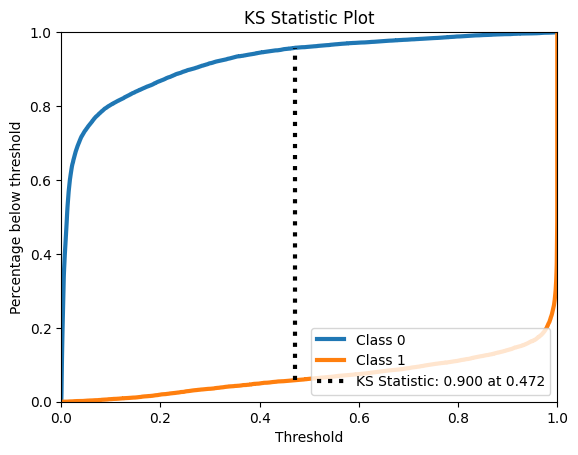



Multi Layer Perceptron - Test

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9912
AUPR:             0.9897


In [14]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('\n\nMulti Layer Perceptron - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

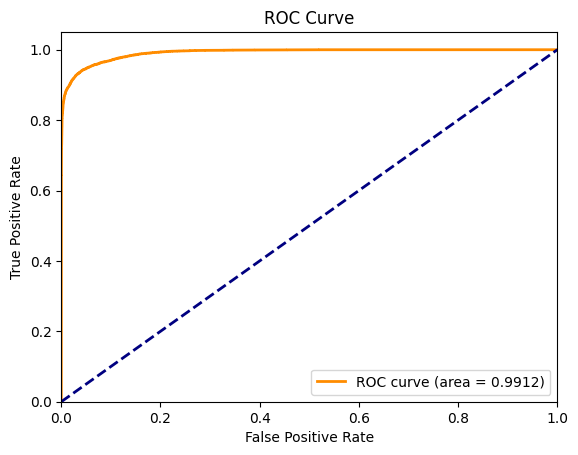

In [15]:
plot_roc_curve(mlp_pred_scores, y_test)

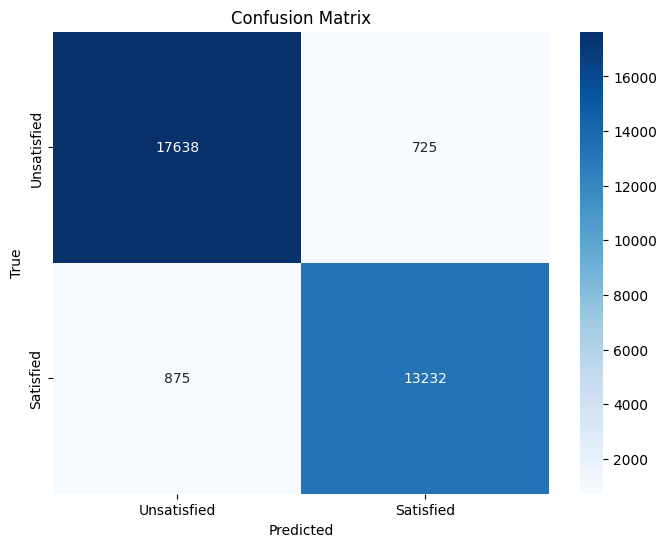

In [16]:
plot_confusion_matrix(y_pred=mlp_pred_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC e o K-S

In [83]:
def objective(trial):

    global x_train
    global y_train

    global X_val
    global y_val

    global X_test
    global y_test

    global early_stopping
    
    params = {
        'n_hidden_layers': trial.suggest_int('n_hidden_layers', 10, 500, step=10),
        'activation_function' : trial.suggest_categorical('activation_function', ['relu', 'sigmoid', 'softmax', 'tanh']),
        'optimizer' : trial.suggest_categorical('optimizer', ['adam', 'SGD', 'rmsprop']),
        'batch_size': trial.suggest_int('batch_size', 32, 160, step=32)
    }

    trial.set_user_attr("n_hidden_layers", params["n_hidden_layers"])
    trial.set_user_attr("activation_function", params["activation_function"])
    trial.set_user_attr("optimizer", params["optimizer"])
    trial.set_user_attr("batch_size", params["batch_size"])

    model = Sequential([
        # Input layer
        Input(shape=(X_train.shape[1],)),

        # Hidden layers
        Dense(params['n_hidden_layers'], activation=params['activation_function']),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=params['optimizer'], 
        loss='binary_crossentropy', 
        metrics=['auc']
    )

    history = model.fit(
        X_train,
        y_train, 
        epochs=100, 
        batch_size=params['n_hidden_layers'], 
        validation_data=(X_val, y_val), 
        callbacks=[early_stopping]
    )

    # mlp_pred_scores = model.predict(X_test)
    # mlp_pred_class = np.argmax(mlp_pred_scores, axis=1)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_scores = model.predict(X_test, batch_size=params['batch_size'])
    prob_class_0 = 1 - y_pred_test_scores

    y_pred_test_scores = np.hstack((prob_class_0, y_pred_test_scores))
    y_pred_test_class = np.argmax(mlp_pred_scores, axis=1)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, y_pred_test_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nMLP\nn_hidden_layers: {params["n_hidden_layers"]}\nactivation_function:{params["activation_function"]}\noptimizer:{params["optimizer"]}\nbatch_size:{params["batch_size"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    return auroc, ks_statistic


[I 2024-07-18 18:06:30,110] A new study created in memory with name: no-name-d24e36e5-161d-4866-9762-8195810f458a


Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8799 - loss: 0.4362 - val_auc: 0.9265 - val_loss: 0.3480
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9224 - loss: 0.3549 - val_auc: 0.9275 - val_loss: 0.3445
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9246 - loss: 0.3485 - val_auc: 0.9279 - val_loss: 0.3394
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9259 - loss: 0.3447 - val_auc: 0.9297 - val_loss: 0.3358
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9271 - loss: 0.3413 - val_auc: 0.9335 - val_loss: 0.3261
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


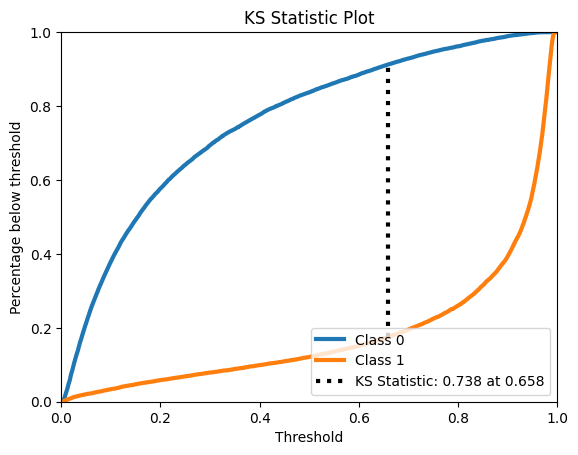

[I 2024-07-18 18:06:34,026] Trial 0 finished with values: [0.9267963472289553, 0.7376041771534284] and parameters: {'n_hidden_layers': 250, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. 




MLP
n_hidden_layers: 250
activation_function:tanh
optimizer:adam
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9268
AUPR:             0.9308
Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7927 - loss: 0.6603 - val_auc: 0.8966 - val_loss: 0.5250
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8730 - loss: 0.5098 - val_auc: 0.9208 - val_loss: 0.4256
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8956 - loss: 0.4386 - val_auc: 0.9261 - val_loss: 0.3809
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9027 - loss: 0.4074 - val_auc: 0.9282 - val_loss: 0.3579
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9073 - loss: 0.3898 - val_auc: 0.9287 - val_loss: 0.3440
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


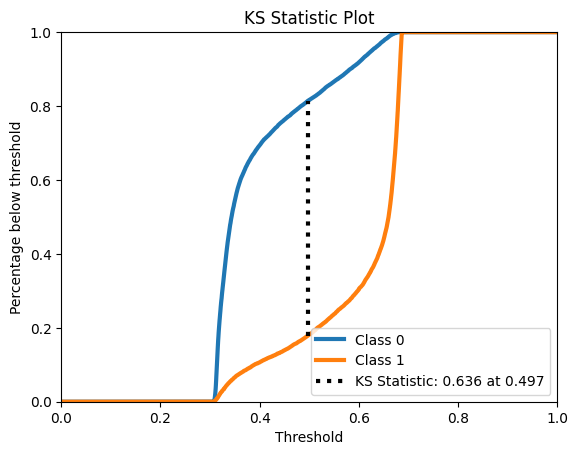

[I 2024-07-18 18:06:38,871] Trial 1 finished with values: [0.8970856143348994, 0.6357972108990126] and parameters: {'n_hidden_layers': 180, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 128}. 




MLP
n_hidden_layers: 180
activation_function:softmax
optimizer:adam
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8971
AUPR:             0.8942
Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8150 - loss: 0.5310 - val_auc: 0.9181 - val_loss: 0.3730
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9126 - loss: 0.3809 - val_auc: 0.9242 - val_loss: 0.3755
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9190 - loss: 0.3673 - val_auc: 0.9257 - val_loss: 0.3641
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9188 - loss: 0.3680 - val_auc: 0.9263 - val_loss: 0.3559
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9190 - loss: 0.3662 - val_auc: 0.9267 - val_loss: 0.3515
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step


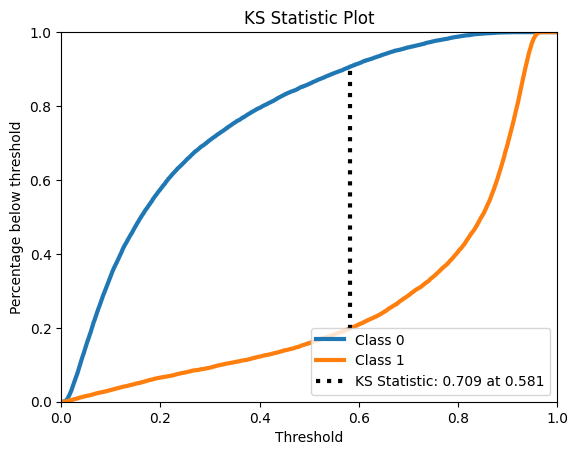

[I 2024-07-18 18:06:43,208] Trial 2 finished with values: [0.9183231267429353, 0.7088376113414948] and parameters: {'n_hidden_layers': 340, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 340
activation_function:sigmoid
optimizer:rmsprop
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9183
AUPR:             0.9221
Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.4998 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.4998 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.5001 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.4997 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6931
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.4998 - loss: 0.6931 - val_auc: 0.5000 - val_loss: 0.6931
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


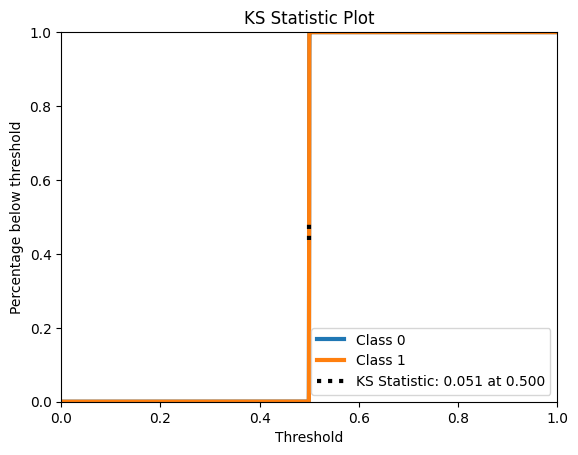

[I 2024-07-18 18:06:47,203] Trial 3 finished with values: [0.46368918083042754, 0.05084973030032047] and parameters: {'n_hidden_layers': 280, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 280
activation_function:softmax
optimizer:SGD
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.4637
AUPR:             0.3904
Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8009 - loss: 0.5461 - val_auc: 0.9150 - val_loss: 0.3797
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9082 - loss: 0.3902 - val_auc: 0.9233 - val_loss: 0.3579
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9141 - loss: 0.3772 - val_auc: 0.9250 - val_loss: 0.3588
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9193 - loss: 0.3662 - val_auc: 0.9260 - val_loss: 0.3595
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9212 - loss: 0.3625 - val_auc: 0.9264 - val_loss: 0.3516
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


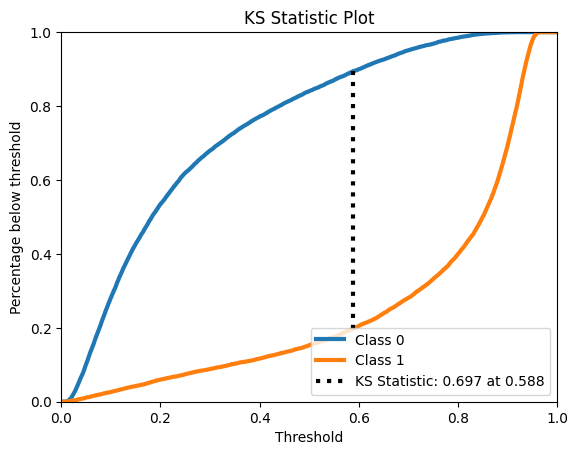

[I 2024-07-18 18:06:50,963] Trial 4 finished with values: [0.9151498801716713, 0.6972555515548634] and parameters: {'n_hidden_layers': 430, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 430
activation_function:sigmoid
optimizer:rmsprop
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9151
AUPR:             0.9185
Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7674 - loss: 0.5759 - val_auc: 0.9167 - val_loss: 0.3754
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9114 - loss: 0.3834 - val_auc: 0.9243 - val_loss: 0.3546
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9171 - loss: 0.3712 - val_auc: 0.9258 - val_loss: 0.3517
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9197 - loss: 0.3656 - val_auc: 0.9264 - val_loss: 0.3489
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9198 - loss: 0.3646 - val_auc: 0.9266 - val_loss: 0.3472
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


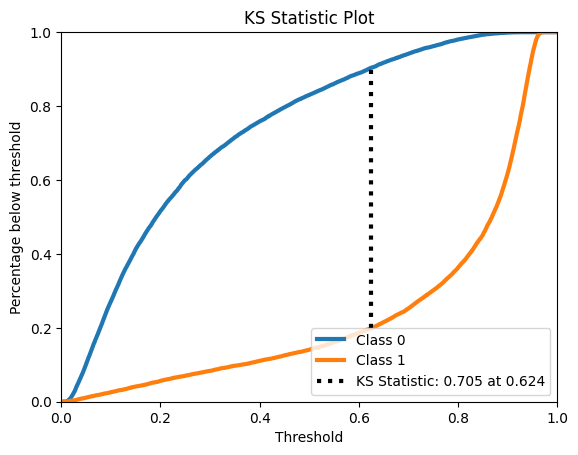

[I 2024-07-18 18:06:55,375] Trial 5 finished with values: [0.9168992317493654, 0.7048880708026083] and parameters: {'n_hidden_layers': 330, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 330
activation_function:sigmoid
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9169
AUPR:             0.9207
Epoch 1/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.8872 - loss: 0.4266 - val_auc: 0.9428 - val_loss: 0.2968
Epoch 2/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.9439 - loss: 0.2944 - val_auc: 0.9663 - val_loss: 0.2373
Epoch 3/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - auc: 0.9624 - loss: 0.2457 - val_auc: 0.9740 - val_loss: 0.2116
Epoch 4/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - auc: 0.9702 - loss: 0.2203 - val_auc: 0.9787 - val_loss: 0.1918
Epoch 5/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - auc: 0.9752 - loss: 0.2025 - val_auc: 0.9815 - val_loss: 0.1788
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


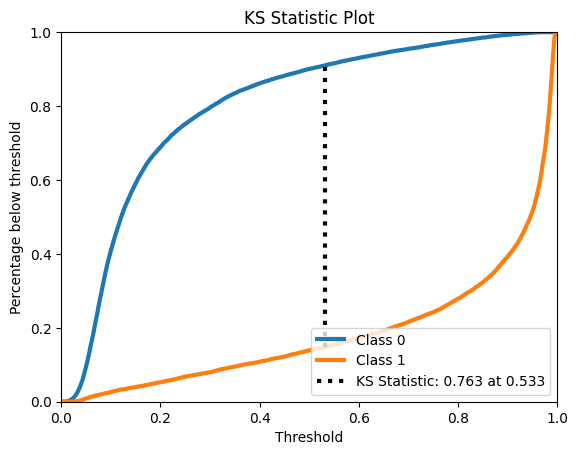

[I 2024-07-18 18:07:03,998] Trial 6 finished with values: [0.9423130525648834, 0.762645490048651] and parameters: {'n_hidden_layers': 50, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 50
activation_function:relu
optimizer:rmsprop
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9423
AUPR:             0.9444
Epoch 1/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.7940 - loss: 0.6104 - val_auc: 0.9174 - val_loss: 0.4199
Epoch 2/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.8933 - loss: 0.4301 - val_auc: 0.9256 - val_loss: 0.3535
Epoch 3/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9079 - loss: 0.3838 - val_auc: 0.9288 - val_loss: 0.3345
Epoch 4/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - auc: 0.9110 - loss: 0.3707 - val_auc: 0.9306 - val_loss: 0.3265
Epoch 5/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - auc: 0.9141 - loss: 0.3623 - val_auc: 0.9322 - val_loss: 0.3202
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


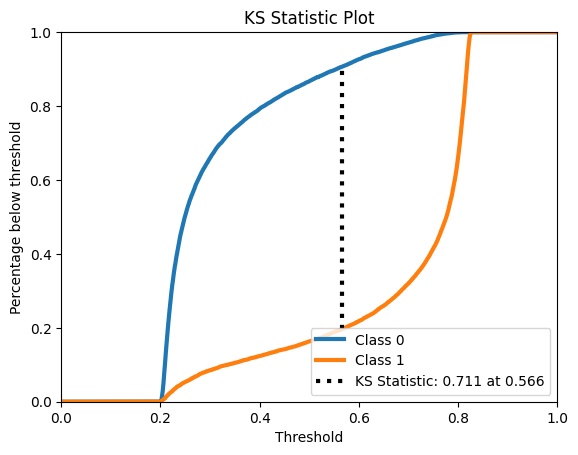

[I 2024-07-18 18:07:12,801] Trial 7 finished with values: [0.9182569379411964, 0.7109416941316802] and parameters: {'n_hidden_layers': 50, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 50
activation_function:softmax
optimizer:rmsprop
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9183
AUPR:             0.9227
Epoch 1/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8896 - loss: 0.4278 - val_auc: 0.9453 - val_loss: 0.2958
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9495 - loss: 0.2837 - val_auc: 0.9700 - val_loss: 0.2399
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9679 - loss: 0.2310 - val_auc: 0.9761 - val_loss: 0.2015
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9745 - loss: 0.2061 - val_auc: 0.9794 - val_loss: 0.2042
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9782 - loss: 0.1907 - val_auc: 0.9817 - val_loss: 0.1941
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step


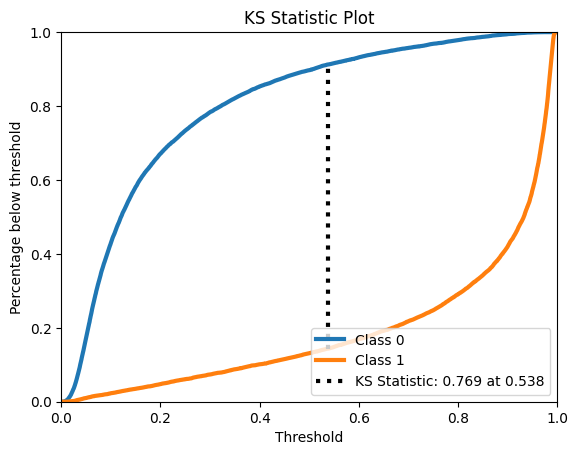

[I 2024-07-18 18:07:17,914] Trial 8 finished with values: [0.9455410652932842, 0.7689032810865275] and parameters: {'n_hidden_layers': 120, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 120
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9455
AUPR:             0.9461
Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8835 - loss: 0.4332 - val_auc: 0.9266 - val_loss: 0.3462
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9227 - loss: 0.3548 - val_auc: 0.9266 - val_loss: 0.3721
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9221 - loss: 0.3546 - val_auc: 0.9284 - val_loss: 0.3585
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9260 - loss: 0.3458 - val_auc: 0.9279 - val_loss: 0.3541
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9260 - loss: 0.3443 - val_auc: 0.9298 - val_loss: 0.3396
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


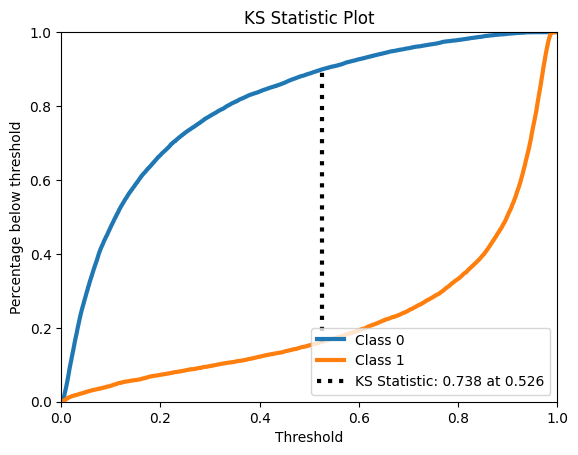

[I 2024-07-18 18:07:21,852] Trial 9 finished with values: [0.9268024098390761, 0.7375827563170323] and parameters: {'n_hidden_layers': 270, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 270
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9268
AUPR:             0.9305
Epoch 1/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.4965 - loss: 0.6933 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 2/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.4965 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.4987 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 4/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.5005 - loss: 0.6932 - val_auc: 0.5000 - val_loss: 0.6931
Epoch 5/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.5025 - loss: 0.6931 - val_auc: 0.5000 - val_loss: 0.6931
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


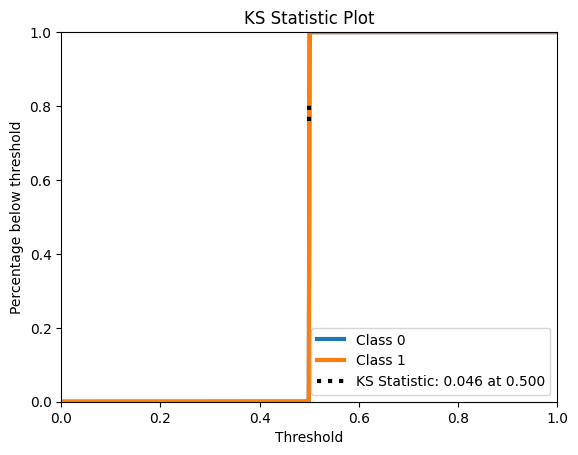

[I 2024-07-18 18:07:26,209] Trial 10 finished with values: [0.43199401339157806, 0.045550379824936704] and parameters: {'n_hidden_layers': 220, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 220
activation_function:softmax
optimizer:SGD
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.4320
AUPR:             0.4123
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7952 - loss: 0.6079 - val_auc: 0.8753 - val_loss: 0.4937
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8688 - loss: 0.4865 - val_auc: 0.8836 - val_loss: 0.4534
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8780 - loss: 0.4554 - val_auc: 0.8919 - val_loss: 0.4327
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8866 - loss: 0.4380 - val_auc: 0.8989 - val_loss: 0.4176
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8939 - loss: 0.4237 - val_auc: 0.9049 - val_loss: 0.4055
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


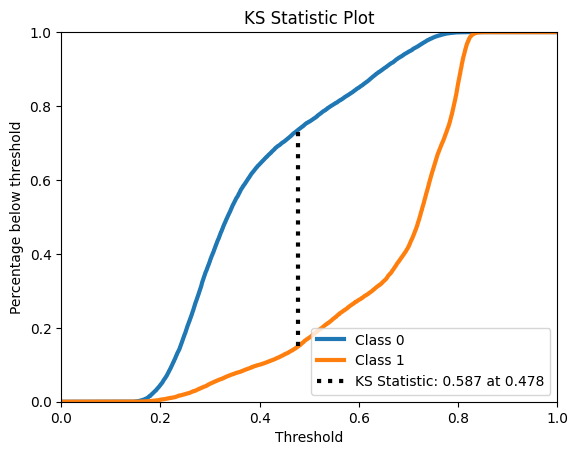

[I 2024-07-18 18:07:29,824] Trial 11 finished with values: [0.8750111258836003, 0.5866211161401501] and parameters: {'n_hidden_layers': 460, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 460
activation_function:tanh
optimizer:SGD
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8750
AUPR:             0.8640
Epoch 1/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.8806 - loss: 0.4284 - val_auc: 0.9464 - val_loss: 0.2905
Epoch 2/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - auc: 0.9476 - loss: 0.2850 - val_auc: 0.9664 - val_loss: 0.2356
Epoch 3/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - auc: 0.9637 - loss: 0.2402 - val_auc: 0.9751 - val_loss: 0.2069
Epoch 4/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - auc: 0.9717 - loss: 0.2150 - val_auc: 0.9792 - val_loss: 0.1869
Epoch 5/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9755 - loss: 0.1997 - val_auc: 0.9825 - val_loss: 0.1750
Epoch 6/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - auc: 0.9791 - loss: 0.1857 - val_auc: 0.9830 - val_loss: 0.1769
Epoch 7/100
1225/1225 ━━━━━━━━━━━━━

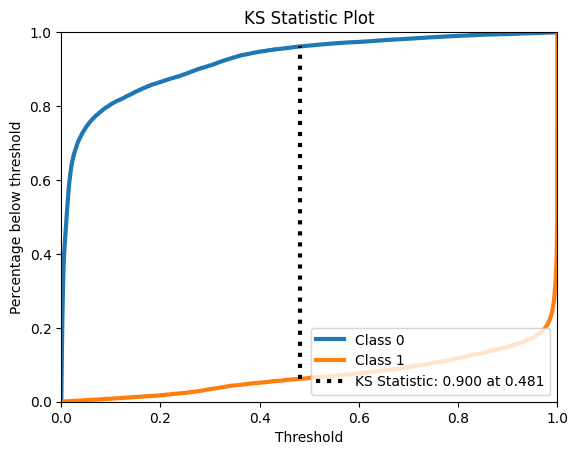

[I 2024-07-18 18:08:09,579] Trial 12 finished with values: [0.9906909750735002, 0.8998487536082326] and parameters: {'n_hidden_layers': 60, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 60
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9907
AUPR:             0.9893
Epoch 1/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - auc: 0.8061 - loss: 0.5322 - val_auc: 0.9125 - val_loss: 0.3842
Epoch 2/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - auc: 0.9106 - loss: 0.3846 - val_auc: 0.9234 - val_loss: 0.3557
Epoch 3/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - auc: 0.9210 - loss: 0.3596 - val_auc: 0.9263 - val_loss: 0.3459
Epoch 4/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - auc: 0.9233 - loss: 0.3531 - val_auc: 0.9273 - val_loss: 0.3424
Epoch 5/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - auc: 0.9245 - loss: 0.3499 - val_auc: 0.9278 - val_loss: 0.3473
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step


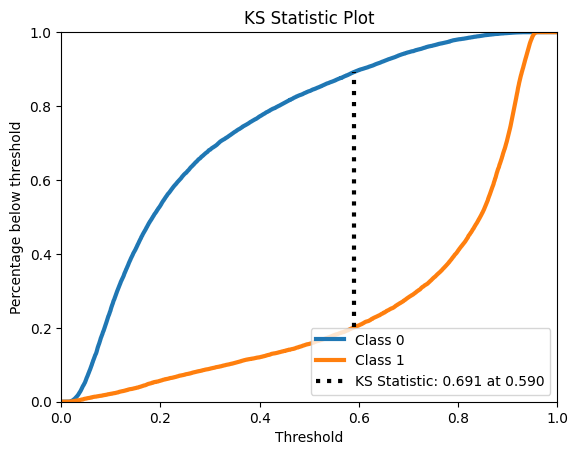

[I 2024-07-18 18:08:17,745] Trial 13 finished with values: [0.9126165371767649, 0.6912813076921482] and parameters: {'n_hidden_layers': 50, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 32}. 




MLP
n_hidden_layers: 50
activation_function:tanh
optimizer:SGD
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9126
AUPR:             0.9108
Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8821 - loss: 0.4401 - val_auc: 0.9358 - val_loss: 0.3200
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9353 - loss: 0.3173 - val_auc: 0.9560 - val_loss: 0.2700
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9562 - loss: 0.2664 - val_auc: 0.9690 - val_loss: 0.2347
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9683 - loss: 0.2309 - val_auc: 0.9741 - val_loss: 0.2098
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9732 - loss: 0.2121 - val_auc: 0.9779 - val_loss: 0.1960
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


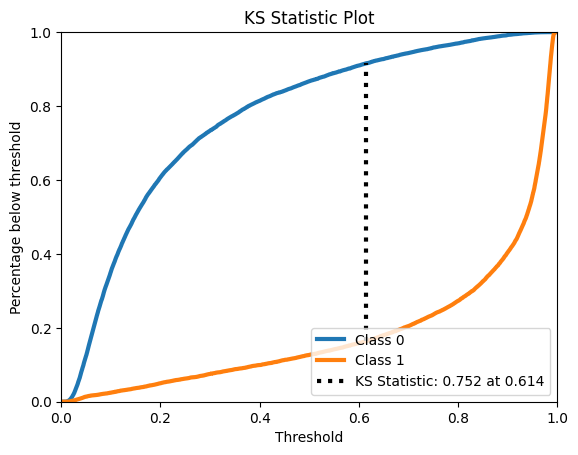

[I 2024-07-18 18:08:21,536] Trial 14 finished with values: [0.9356517167487868, 0.7519628158677295] and parameters: {'n_hidden_layers': 420, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 420
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9357
AUPR:             0.9383
Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8848 - loss: 0.4316 - val_auc: 0.9445 - val_loss: 0.3157
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9476 - loss: 0.2873 - val_auc: 0.9662 - val_loss: 0.2423
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9670 - loss: 0.2341 - val_auc: 0.9750 - val_loss: 0.2099
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9744 - loss: 0.2070 - val_auc: 0.9800 - val_loss: 0.2370
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9778 - loss: 0.1926 - val_auc: 0.9814 - val_loss: 0.1805
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


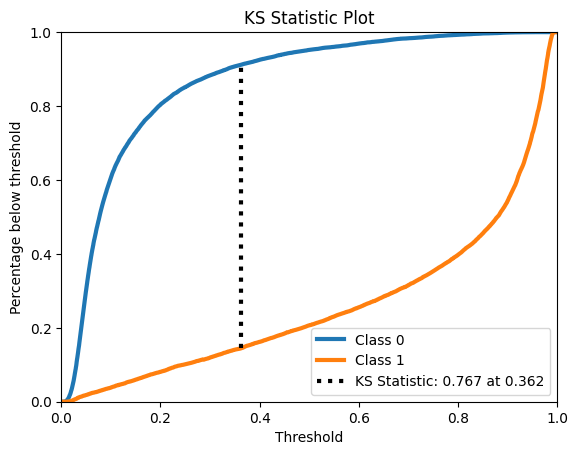

[I 2024-07-18 18:08:25,429] Trial 15 finished with values: [0.9442287582267795, 0.7672522090319566] and parameters: {'n_hidden_layers': 200, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 200
activation_function:relu
optimizer:rmsprop
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9442
AUPR:             0.9453
Epoch 1/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8989 - loss: 0.4108 - val_auc: 0.9273 - val_loss: 0.3459
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9235 - loss: 0.3511 - val_auc: 0.9286 - val_loss: 0.3405
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9258 - loss: 0.3452 - val_auc: 0.9306 - val_loss: 0.3316
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9289 - loss: 0.3375 - val_auc: 0.9360 - val_loss: 0.3196
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9355 - loss: 0.3209 - val_auc: 0.9434 - val_loss: 0.3001
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


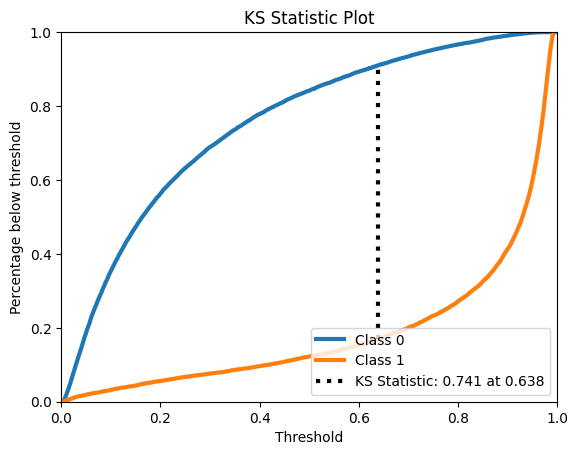

[I 2024-07-18 18:08:30,084] Trial 16 finished with values: [0.9275968433832397, 0.7409879126841002] and parameters: {'n_hidden_layers': 140, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 140
activation_function:tanh
optimizer:rmsprop
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9276
AUPR:             0.9319
Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8752 - loss: 0.4481 - val_auc: 0.9387 - val_loss: 0.3112
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9433 - loss: 0.2987 - val_auc: 0.9672 - val_loss: 0.2393
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9671 - loss: 0.2357 - val_auc: 0.9753 - val_loss: 0.2096
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9736 - loss: 0.2108 - val_auc: 0.9789 - val_loss: 0.1902
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9773 - loss: 0.1947 - val_auc: 0.9817 - val_loss: 0.1785
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step


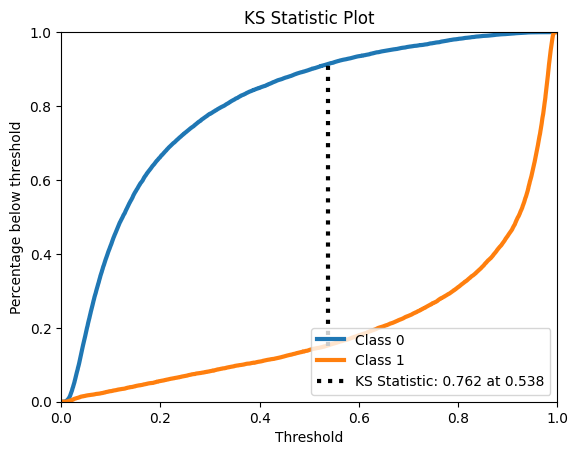

[I 2024-07-18 18:08:34,429] Trial 17 finished with values: [0.9385793861118732, 0.7618127564813655] and parameters: {'n_hidden_layers': 310, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 310
activation_function:relu
optimizer:adam
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9386
AUPR:             0.9413
Epoch 1/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 2s 986us/step - auc: 0.8392 - loss: 0.5101 - val_auc: 0.9112 - val_loss: 0.3877
Epoch 2/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - auc: 0.9091 - loss: 0.3895 - val_auc: 0.9228 - val_loss: 0.3601
Epoch 3/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - auc: 0.9203 - loss: 0.3623 - val_auc: 0.9259 - val_loss: 0.3471
Epoch 4/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - auc: 0.9240 - loss: 0.3529 - val_auc: 0.9271 - val_loss: 0.3465
Epoch 5/100
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - auc: 0.9225 - loss: 0.3558 - val_auc: 0.9278 - val_loss: 0.3407
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


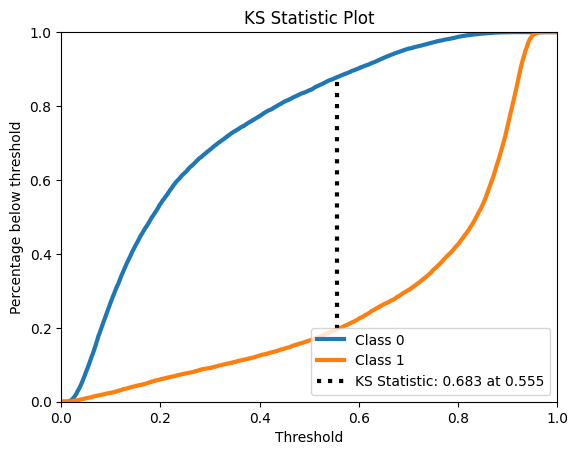

[I 2024-07-18 18:08:42,310] Trial 18 finished with values: [0.9117328630153032, 0.6826351416499227] and parameters: {'n_hidden_layers': 50, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 50
activation_function:tanh
optimizer:SGD
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9117
AUPR:             0.9141
Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7902 - loss: 0.5556 - val_auc: 0.9139 - val_loss: 0.3949
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9069 - loss: 0.3929 - val_auc: 0.9230 - val_loss: 0.3690
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9141 - loss: 0.3764 - val_auc: 0.9249 - val_loss: 0.3671
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9187 - loss: 0.3673 - val_auc: 0.9259 - val_loss: 0.3536
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9191 - loss: 0.3666 - val_auc: 0.9262 - val_loss: 0.3632
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


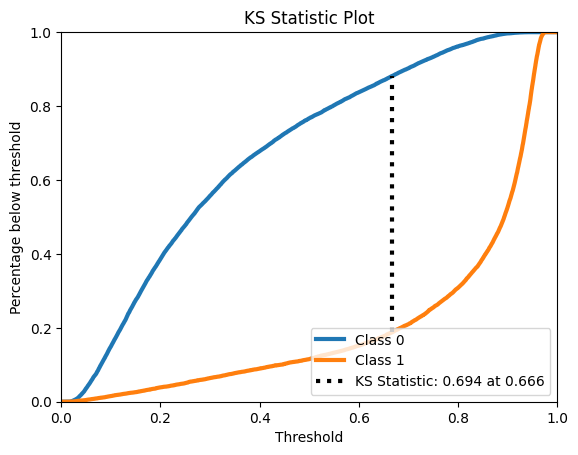

[I 2024-07-18 18:08:46,291] Trial 19 finished with values: [0.9141515221179632, 0.6937658467720902] and parameters: {'n_hidden_layers': 470, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 470
activation_function:sigmoid
optimizer:rmsprop
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9142
AUPR:             0.9174
Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8617 - loss: 0.4589 - val_auc: 0.9374 - val_loss: 0.3154
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9422 - loss: 0.3021 - val_auc: 0.9662 - val_loss: 0.2436
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9658 - loss: 0.2398 - val_auc: 0.9743 - val_loss: 0.2110
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9731 - loss: 0.2120 - val_auc: 0.9781 - val_loss: 0.1930
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9773 - loss: 0.1948 - val_auc: 0.9814 - val_loss: 0.1860
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step


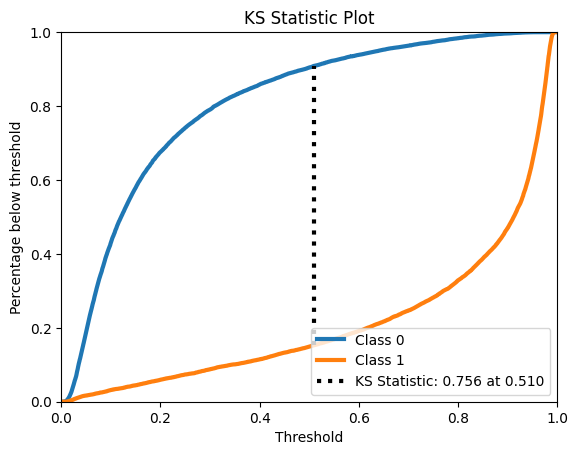

[I 2024-07-18 18:08:50,654] Trial 20 finished with values: [0.9371875200747961, 0.7559684698104463] and parameters: {'n_hidden_layers': 320, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 320
activation_function:relu
optimizer:adam
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9372
AUPR:             0.9401
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7840 - loss: 0.5779 - val_auc: 0.8848 - val_loss: 0.4467
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8815 - loss: 0.4447 - val_auc: 0.9040 - val_loss: 0.4053
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9010 - loss: 0.4071 - val_auc: 0.9148 - val_loss: 0.3800
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9103 - loss: 0.3872 - val_auc: 0.9200 - val_loss: 0.3659
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9168 - loss: 0.3717 - val_auc: 0.9227 - val_loss: 0.3577
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step


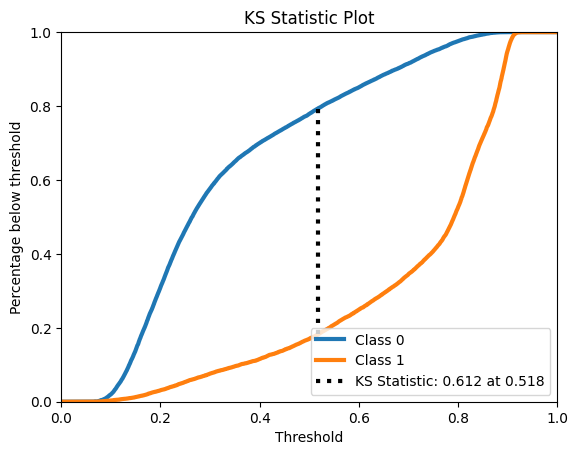

[I 2024-07-18 18:08:55,534] Trial 21 finished with values: [0.8845826110653092, 0.612048278172209] and parameters: {'n_hidden_layers': 160, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 32}. 




MLP
n_hidden_layers: 160
activation_function:tanh
optimizer:SGD
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8846
AUPR:             0.8732
Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7654 - loss: 0.6816 - val_auc: 0.8859 - val_loss: 0.6079
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8681 - loss: 0.5838 - val_auc: 0.9041 - val_loss: 0.5114
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8826 - loss: 0.5036 - val_auc: 0.9199 - val_loss: 0.4433
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8944 - loss: 0.4551 - val_auc: 0.9244 - val_loss: 0.4048
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8982 - loss: 0.4282 - val_auc: 0.9264 - val_loss: 0.3808
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


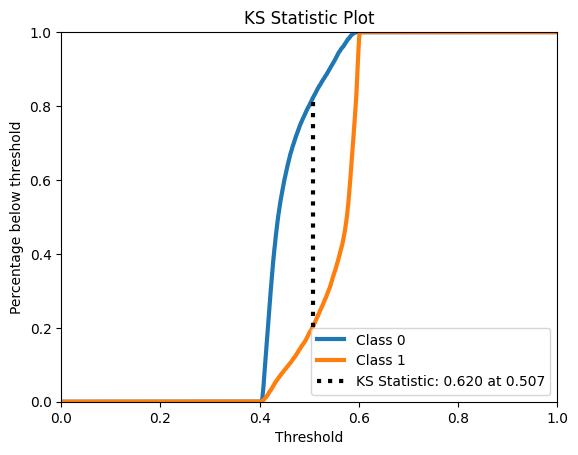

[I 2024-07-18 18:09:00,630] Trial 22 finished with values: [0.8863257494809598, 0.6198159351420155] and parameters: {'n_hidden_layers': 340, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 96}. 




MLP
n_hidden_layers: 340
activation_function:softmax
optimizer:adam
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8863
AUPR:             0.8790
Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7648 - loss: 0.6105 - val_auc: 0.8670 - val_loss: 0.4900
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8640 - loss: 0.4827 - val_auc: 0.8831 - val_loss: 0.4487
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8786 - loss: 0.4513 - val_auc: 0.8951 - val_loss: 0.4252
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8930 - loss: 0.4260 - val_auc: 0.9036 - val_loss: 0.4077
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9005 - loss: 0.4108 - val_auc: 0.9099 - val_loss: 0.3940
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step


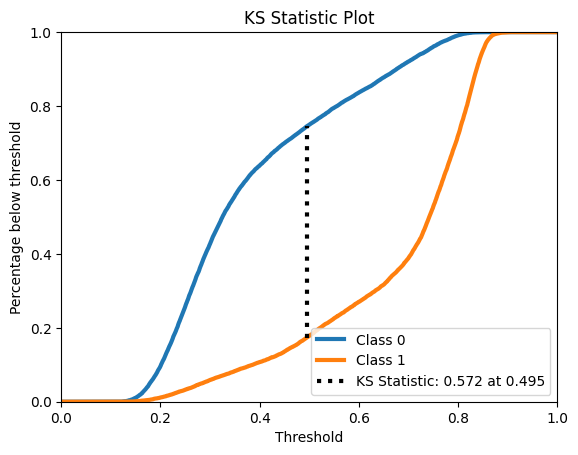

[I 2024-07-18 18:09:04,907] Trial 23 finished with values: [0.8660185919812086, 0.5717721838576676] and parameters: {'n_hidden_layers': 330, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 32}. 




MLP
n_hidden_layers: 330
activation_function:tanh
optimizer:SGD
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8660
AUPR:             0.8498
Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8902 - loss: 0.4325 - val_auc: 0.9373 - val_loss: 0.3169
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9390 - loss: 0.3096 - val_auc: 0.9579 - val_loss: 0.2602
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9605 - loss: 0.2548 - val_auc: 0.9715 - val_loss: 0.2255
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9689 - loss: 0.2288 - val_auc: 0.9758 - val_loss: 0.2090
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9736 - loss: 0.2100 - val_auc: 0.9793 - val_loss: 0.1893
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


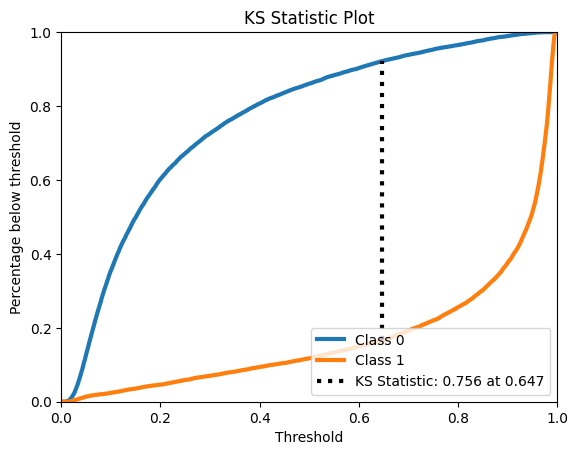

[I 2024-07-18 18:09:08,770] Trial 24 finished with values: [0.9371669369247393, 0.7562128889269103] and parameters: {'n_hidden_layers': 330, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 330
activation_function:relu
optimizer:rmsprop
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9372
AUPR:             0.9398
Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8678 - loss: 0.4455 - val_auc: 0.9372 - val_loss: 0.3105
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9413 - loss: 0.2994 - val_auc: 0.9662 - val_loss: 0.2391
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9669 - loss: 0.2350 - val_auc: 0.9749 - val_loss: 0.2097
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9729 - loss: 0.2119 - val_auc: 0.9789 - val_loss: 0.1907
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9772 - loss: 0.1957 - val_auc: 0.9821 - val_loss: 0.1774
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


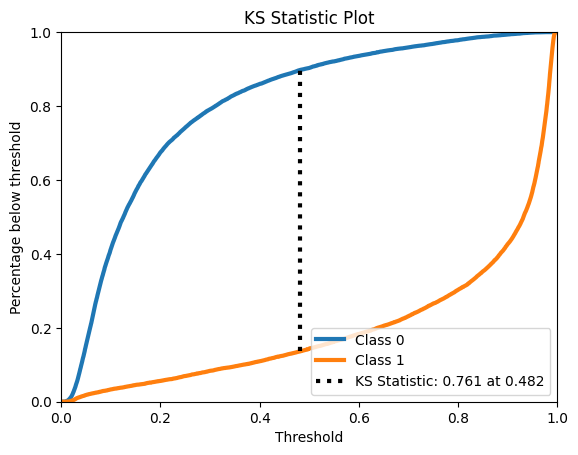

[I 2024-07-18 18:09:13,287] Trial 25 finished with values: [0.9367650096146125, 0.7614682821011509] and parameters: {'n_hidden_layers': 190, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 96}. 




MLP
n_hidden_layers: 190
activation_function:relu
optimizer:adam
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9368
AUPR:             0.9405
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6933 - loss: 0.6403 - val_auc: 0.8687 - val_loss: 0.5095
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8623 - loss: 0.4995 - val_auc: 0.8801 - val_loss: 0.4624
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8765 - loss: 0.4617 - val_auc: 0.8893 - val_loss: 0.4389
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8879 - loss: 0.4380 - val_auc: 0.8973 - val_loss: 0.4219
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8948 - loss: 0.4233 - val_auc: 0.9036 - val_loss: 0.4086
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


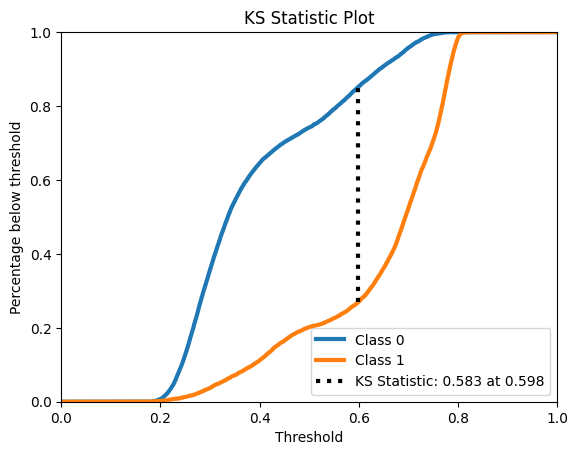

[I 2024-07-18 18:09:16,930] Trial 26 finished with values: [0.8680187032274985, 0.5830024462641488] and parameters: {'n_hidden_layers': 460, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 460
activation_function:tanh
optimizer:SGD
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8680
AUPR:             0.8529
Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.7819 - loss: 0.6601 - val_auc: 0.9004 - val_loss: 0.5227
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8774 - loss: 0.5082 - val_auc: 0.9218 - val_loss: 0.4283
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8959 - loss: 0.4411 - val_auc: 0.9258 - val_loss: 0.3840
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9053 - loss: 0.4047 - val_auc: 0.9280 - val_loss: 0.3597
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9059 - loss: 0.3929 - val_auc: 0.9290 - val_loss: 0.3455
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


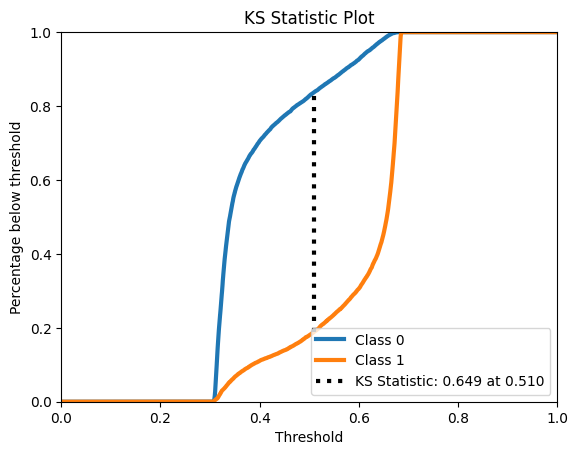

[I 2024-07-18 18:09:21,624] Trial 27 finished with values: [0.9009202567345727, 0.6487648926782319] and parameters: {'n_hidden_layers': 180, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 160}. 




MLP
n_hidden_layers: 180
activation_function:softmax
optimizer:adam
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9009
AUPR:             0.8983
Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7368 - loss: 0.6210 - val_auc: 0.8647 - val_loss: 0.4897
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8631 - loss: 0.4826 - val_auc: 0.8820 - val_loss: 0.4475
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8784 - loss: 0.4493 - val_auc: 0.8948 - val_loss: 0.4231
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8915 - loss: 0.4262 - val_auc: 0.9040 - val_loss: 0.4052
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9004 - loss: 0.4095 - val_auc: 0.9100 - val_loss: 0.3916
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


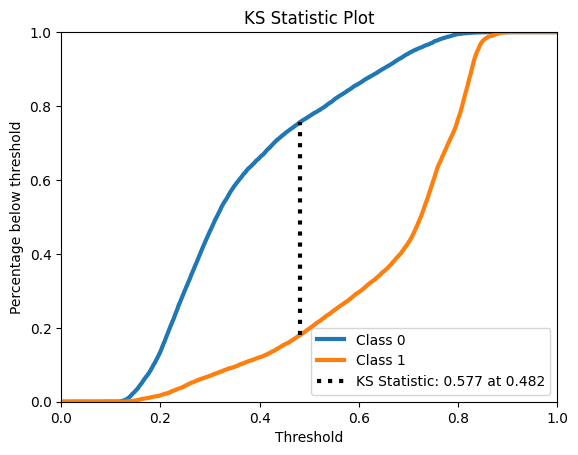

[I 2024-07-18 18:09:25,297] Trial 28 finished with values: [0.8641617501909624, 0.5769044680224454] and parameters: {'n_hidden_layers': 310, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 310
activation_function:tanh
optimizer:SGD
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8642
AUPR:             0.8475
Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8773 - loss: 0.4417 - val_auc: 0.9266 - val_loss: 0.3449
Epoch 2/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9237 - loss: 0.3525 - val_auc: 0.9269 - val_loss: 0.3540
Epoch 3/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9229 - loss: 0.3525 - val_auc: 0.9276 - val_loss: 0.3415
Epoch 4/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9253 - loss: 0.3482 - val_auc: 0.9274 - val_loss: 0.3413
Epoch 5/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9235 - loss: 0.3514 - val_auc: 0.9277 - val_loss: 0.3400
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step


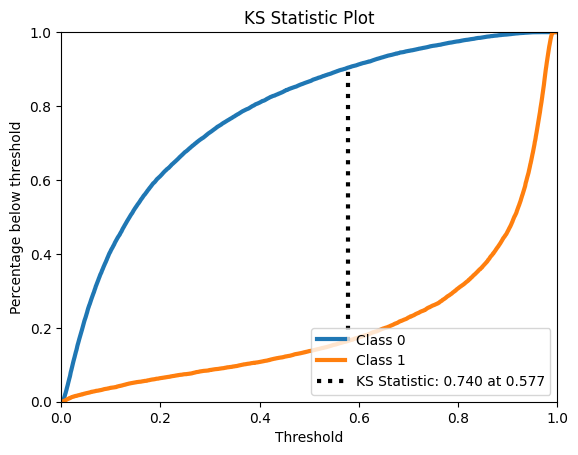

[I 2024-07-18 18:09:29,585] Trial 29 finished with values: [0.9268656995512252, 0.7397366833745717] and parameters: {'n_hidden_layers': 350, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 350
activation_function:tanh
optimizer:rmsprop
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9269
AUPR:             0.9314
Epoch 1/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8843 - loss: 0.4293 - val_auc: 0.9279 - val_loss: 0.3440
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9224 - loss: 0.3547 - val_auc: 0.9293 - val_loss: 0.3453
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9274 - loss: 0.3417 - val_auc: 0.9326 - val_loss: 0.3276
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9297 - loss: 0.3356 - val_auc: 0.9375 - val_loss: 0.3202
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9349 - loss: 0.3226 - val_auc: 0.9459 - val_loss: 0.2940
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


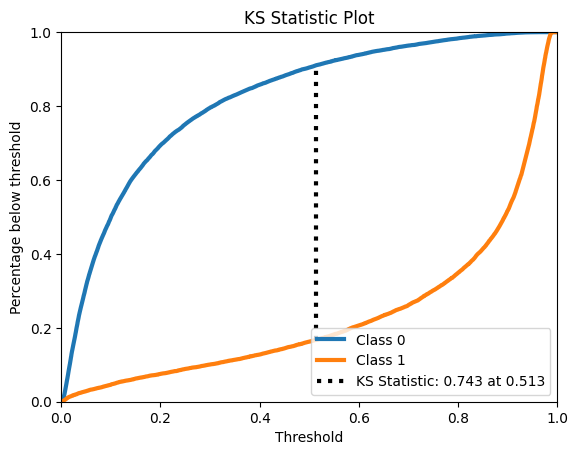

[I 2024-07-18 18:09:34,411] Trial 30 finished with values: [0.9279889848183867, 0.7431905722409484] and parameters: {'n_hidden_layers': 140, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 140
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9280
AUPR:             0.9321
Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8268 - loss: 0.5188 - val_auc: 0.9199 - val_loss: 0.3675
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9137 - loss: 0.3790 - val_auc: 0.9249 - val_loss: 0.3528
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9186 - loss: 0.3679 - val_auc: 0.9262 - val_loss: 0.3523
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9190 - loss: 0.3674 - val_auc: 0.9265 - val_loss: 0.3510
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9220 - loss: 0.3600 - val_auc: 0.9267 - val_loss: 0.3505
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


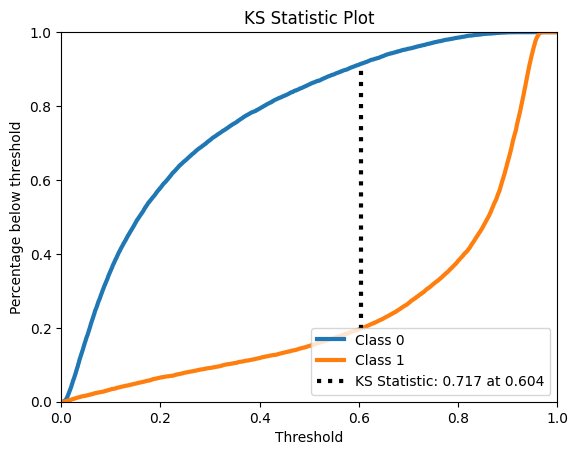

[I 2024-07-18 18:09:38,146] Trial 31 finished with values: [0.9203068432708662, 0.716864437655891] and parameters: {'n_hidden_layers': 280, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 280
activation_function:sigmoid
optimizer:rmsprop
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9203
AUPR:             0.9244
Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7537 - loss: 0.6210 - val_auc: 0.8749 - val_loss: 0.4993
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8678 - loss: 0.4909 - val_auc: 0.8834 - val_loss: 0.4560
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8790 - loss: 0.4569 - val_auc: 0.8921 - val_loss: 0.4338
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8871 - loss: 0.4378 - val_auc: 0.8994 - val_loss: 0.4176
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8967 - loss: 0.4199 - val_auc: 0.9053 - val_loss: 0.4047
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


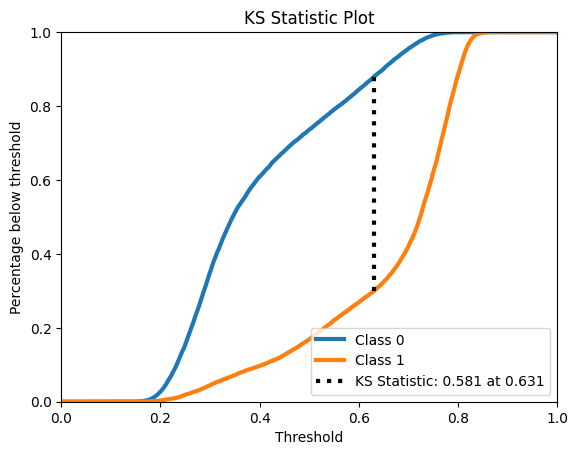

[I 2024-07-18 18:09:41,675] Trial 32 finished with values: [0.8744400013741144, 0.5805544681396058] and parameters: {'n_hidden_layers': 440, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 440
activation_function:tanh
optimizer:SGD
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8744
AUPR:             0.8695
Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8726 - loss: 0.4474 - val_auc: 0.9261 - val_loss: 0.3455
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9221 - loss: 0.3553 - val_auc: 0.9272 - val_loss: 0.3518
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9215 - loss: 0.3566 - val_auc: 0.9275 - val_loss: 0.3631
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9235 - loss: 0.3519 - val_auc: 0.9279 - val_loss: 0.3523
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9242 - loss: 0.3497 - val_auc: 0.9283 - val_loss: 0.3428
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


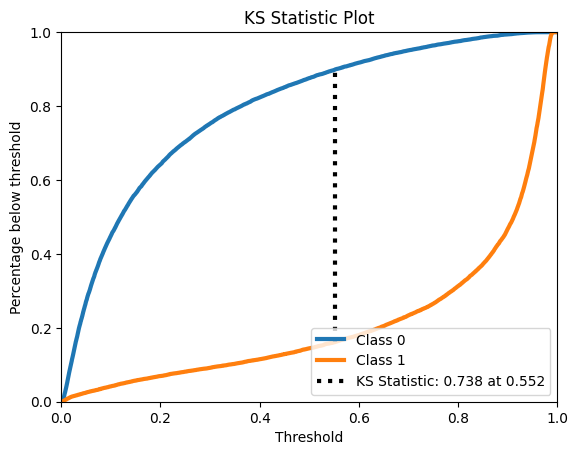

[I 2024-07-18 18:09:45,480] Trial 33 finished with values: [0.9264410601324414, 0.7375940168287942] and parameters: {'n_hidden_layers': 390, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 390
activation_function:tanh
optimizer:rmsprop
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9264
AUPR:             0.9304
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7562 - loss: 0.6234 - val_auc: 0.8653 - val_loss: 0.5093
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8606 - loss: 0.5001 - val_auc: 0.8771 - val_loss: 0.4654
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8708 - loss: 0.4680 - val_auc: 0.8868 - val_loss: 0.4426
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8842 - loss: 0.4434 - val_auc: 0.8955 - val_loss: 0.4262
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8912 - loss: 0.4299 - val_auc: 0.9017 - val_loss: 0.4129
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


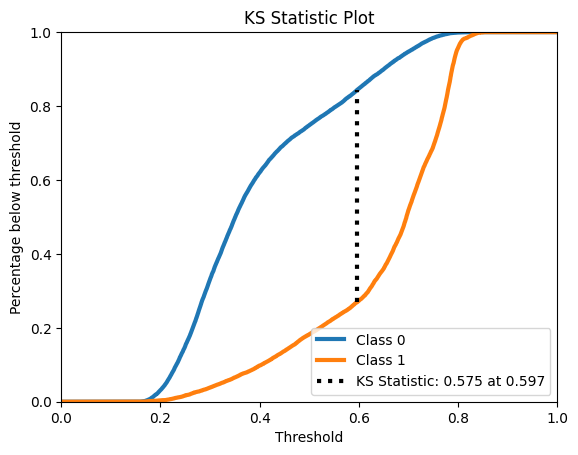

[I 2024-07-18 18:09:49,014] Trial 34 finished with values: [0.8643733760104026, 0.5747188401343988] and parameters: {'n_hidden_layers': 500, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 160}. 




MLP
n_hidden_layers: 500
activation_function:tanh
optimizer:SGD
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8644
AUPR:             0.8379
Epoch 1/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.7679 - loss: 0.5868 - val_auc: 0.8843 - val_loss: 0.4489
Epoch 2/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - auc: 0.8752 - loss: 0.4534 - val_auc: 0.9064 - val_loss: 0.4008
Epoch 3/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - auc: 0.8991 - loss: 0.4092 - val_auc: 0.9180 - val_loss: 0.3717
Epoch 4/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - auc: 0.9098 - loss: 0.3855 - val_auc: 0.9242 - val_loss: 0.3536
Epoch 5/100
735/735 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - auc: 0.9182 - loss: 0.3656 - val_auc: 0.9281 - val_loss: 0.3421
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


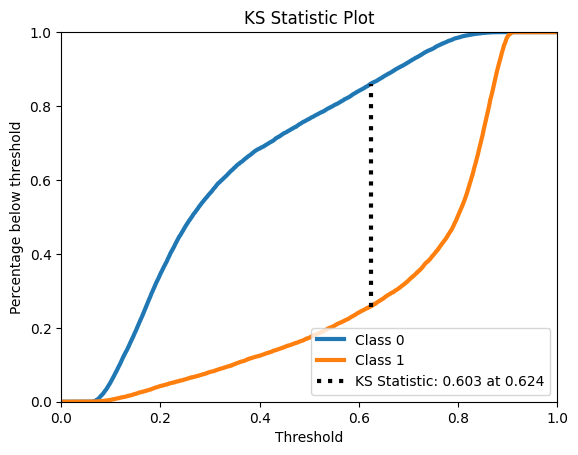

[I 2024-07-18 18:09:53,896] Trial 35 finished with values: [0.8835913926470156, 0.6028396771686553] and parameters: {'n_hidden_layers': 100, 'activation_function': 'relu', 'optimizer': 'SGD', 'batch_size': 128}. 




MLP
n_hidden_layers: 100
activation_function:relu
optimizer:SGD
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8836
AUPR:             0.8812
Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.7893 - loss: 0.6469 - val_auc: 0.8987 - val_loss: 0.5038
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8815 - loss: 0.4857 - val_auc: 0.9194 - val_loss: 0.4027
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9016 - loss: 0.4105 - val_auc: 0.9260 - val_loss: 0.3539
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9119 - loss: 0.3729 - val_auc: 0.9296 - val_loss: 0.3336
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9193 - loss: 0.3512 - val_auc: 0.9327 - val_loss: 0.3201
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step


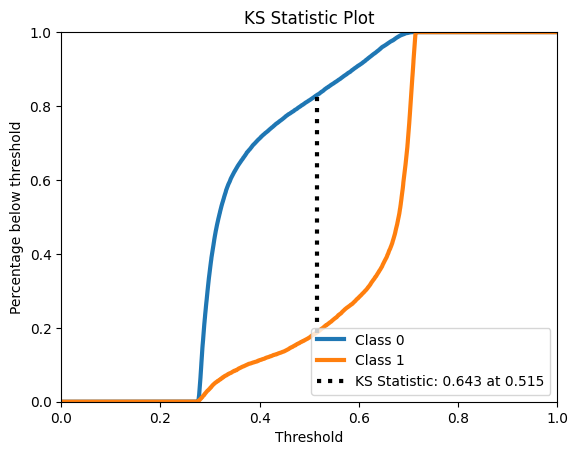

[I 2024-07-18 18:10:00,014] Trial 36 finished with values: [0.8989774941899408, 0.6430834221213297] and parameters: {'n_hidden_layers': 90, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 90
activation_function:softmax
optimizer:rmsprop
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8990
AUPR:             0.8970
Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.5194 - loss: 0.6930 - val_auc: 0.5000 - val_loss: 0.6929
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.5117 - loss: 0.6929 - val_auc: 0.5000 - val_loss: 0.6929
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.5227 - loss: 0.6929 - val_auc: 0.5000 - val_loss: 0.6928
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.5166 - loss: 0.6928 - val_auc: 0.5000 - val_loss: 0.6928
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.5201 - loss: 0.6927 - val_auc: 0.5000 - val_loss: 0.6927
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


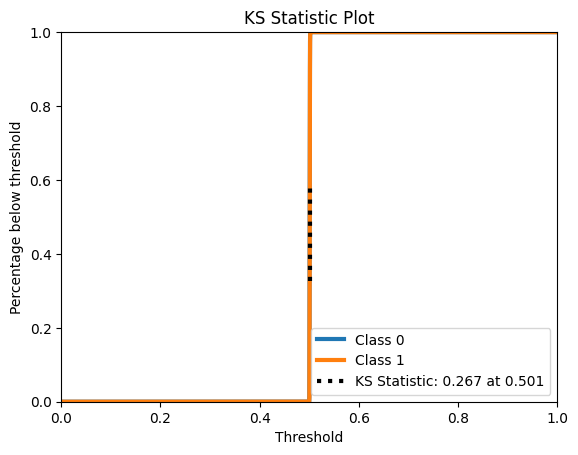

[I 2024-07-18 18:10:04,377] Trial 37 finished with values: [0.6759886371283716, 0.2666991526833558] and parameters: {'n_hidden_layers': 180, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 180
activation_function:softmax
optimizer:SGD
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.6760
AUPR:             0.5783
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7704 - loss: 0.5844 - val_auc: 0.8912 - val_loss: 0.4384
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8869 - loss: 0.4374 - val_auc: 0.9085 - val_loss: 0.4000
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9037 - loss: 0.4043 - val_auc: 0.9172 - val_loss: 0.3769
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9133 - loss: 0.3824 - val_auc: 0.9216 - val_loss: 0.3634
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9167 - loss: 0.3721 - val_auc: 0.9240 - val_loss: 0.3554
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step


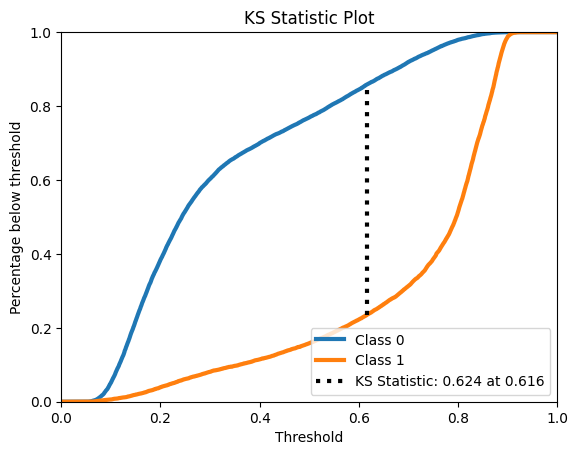

[I 2024-07-18 18:10:08,383] Trial 38 finished with values: [0.890356894952446, 0.6239122522246855] and parameters: {'n_hidden_layers': 160, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 160}. 




MLP
n_hidden_layers: 160
activation_function:tanh
optimizer:SGD
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8904
AUPR:             0.8778
Epoch 1/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - auc: 0.5475 - loss: 0.6921 - val_auc: 0.8120 - val_loss: 0.6837
Epoch 2/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 2s 877us/step - auc: 0.7141 - loss: 0.6738 - val_auc: 0.8733 - val_loss: 0.6206
Epoch 3/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step - auc: 0.7448 - loss: 0.6131 - val_auc: 0.8781 - val_loss: 0.5482
Epoch 4/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - auc: 0.7801 - loss: 0.5606 - val_auc: 0.8854 - val_loss: 0.5000
Epoch 5/100
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - auc: 0.8083 - loss: 0.5332 - val_auc: 0.8929 - val_loss: 0.4685
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


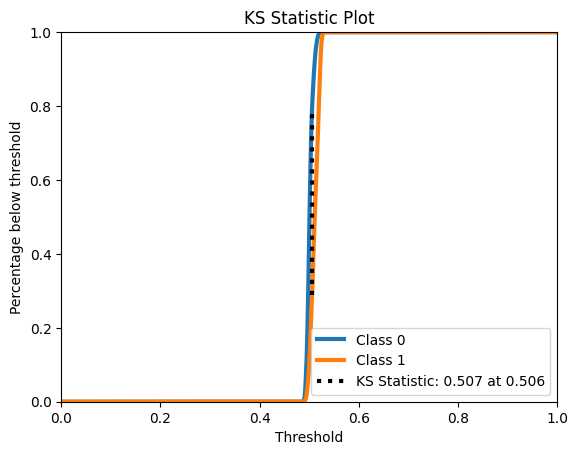

[I 2024-07-18 18:10:17,881] Trial 39 finished with values: [0.8203129468002277, 0.5069490077279113] and parameters: {'n_hidden_layers': 40, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 40
activation_function:softmax
optimizer:SGD
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8203
AUPR:             0.8059
Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.5394 - loss: 0.6926 - val_auc: 0.8033 - val_loss: 0.6912
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7851 - loss: 0.6901 - val_auc: 0.8878 - val_loss: 0.6805
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8493 - loss: 0.6695 - val_auc: 0.8967 - val_loss: 0.6319
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8496 - loss: 0.6219 - val_auc: 0.8938 - val_loss: 0.5815
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8635 - loss: 0.5734 - val_auc: 0.8912 - val_loss: 0.5334
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


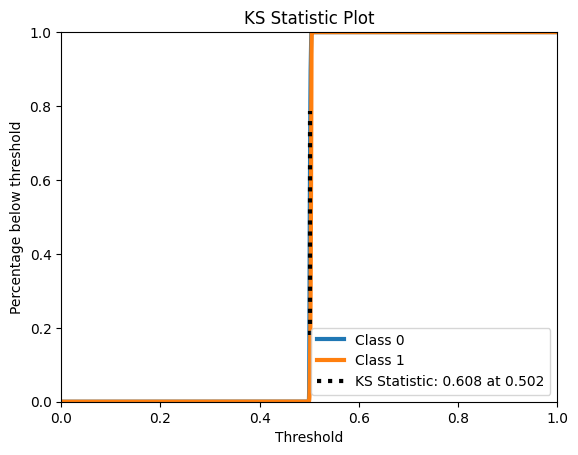

[I 2024-07-18 18:10:21,927] Trial 40 finished with values: [0.8861126779770304, 0.6077066425218443] and parameters: {'n_hidden_layers': 410, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 410
activation_function:softmax
optimizer:rmsprop
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8861
AUPR:             0.8810
Epoch 1/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8065 - loss: 0.5358 - val_auc: 0.9194 - val_loss: 0.3688
Epoch 2/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9136 - loss: 0.3796 - val_auc: 0.9252 - val_loss: 0.3566
Epoch 3/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9177 - loss: 0.3706 - val_auc: 0.9262 - val_loss: 0.3487
Epoch 4/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9199 - loss: 0.3650 - val_auc: 0.9267 - val_loss: 0.3483
Epoch 5/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9223 - loss: 0.3579 - val_auc: 0.9271 - val_loss: 0.3472
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


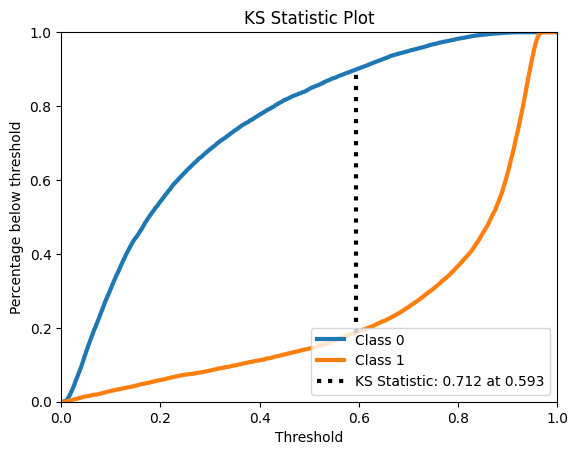

[I 2024-07-18 18:10:26,781] Trial 41 finished with values: [0.9195578571058506, 0.7122719245976059] and parameters: {'n_hidden_layers': 240, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 240
activation_function:sigmoid
optimizer:adam
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9196
AUPR:             0.9234
Epoch 1/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.8714 - loss: 0.4394 - val_auc: 0.9280 - val_loss: 0.3399
Epoch 2/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9239 - loss: 0.3506 - val_auc: 0.9305 - val_loss: 0.3330
Epoch 3/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9277 - loss: 0.3392 - val_auc: 0.9370 - val_loss: 0.3225
Epoch 4/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9331 - loss: 0.3248 - val_auc: 0.9481 - val_loss: 0.2882
Epoch 5/100
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9449 - loss: 0.2961 - val_auc: 0.9573 - val_loss: 0.2639
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


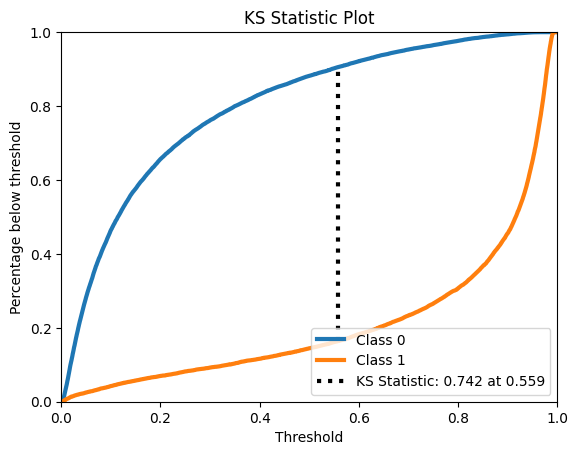

[I 2024-07-18 18:10:32,412] Trial 42 finished with values: [0.9282138263944317, 0.7416478589677146] and parameters: {'n_hidden_layers': 110, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 110
activation_function:tanh
optimizer:adam
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9282
AUPR:             0.9325
Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.8832 - loss: 0.4371 - val_auc: 0.9271 - val_loss: 0.3520
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9235 - loss: 0.3528 - val_auc: 0.9272 - val_loss: 0.3450
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9235 - loss: 0.3513 - val_auc: 0.9279 - val_loss: 0.3427
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9267 - loss: 0.3436 - val_auc: 0.9287 - val_loss: 0.3402
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9248 - loss: 0.3485 - val_auc: 0.9308 - val_loss: 0.3341
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


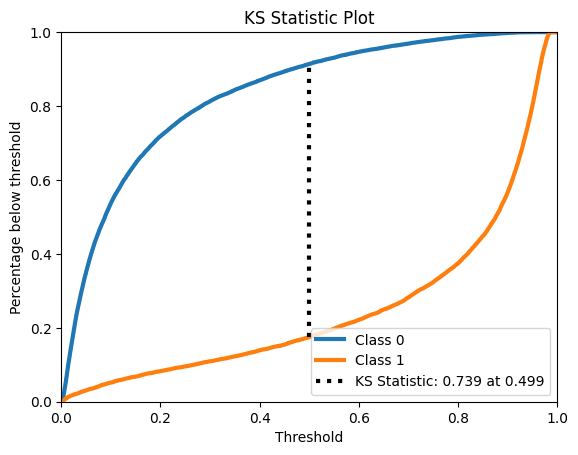

[I 2024-07-18 18:10:36,513] Trial 43 finished with values: [0.9274484397205986, 0.7394782474880672] and parameters: {'n_hidden_layers': 360, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 96}. 




MLP
n_hidden_layers: 360
activation_function:tanh
optimizer:adam
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9274
AUPR:             0.9315
Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5384 - loss: 0.6969 - val_auc: 0.8526 - val_loss: 0.6522
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6558 - loss: 0.6592 - val_auc: 0.8738 - val_loss: 0.6193
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7341 - loss: 0.6276 - val_auc: 0.8796 - val_loss: 0.5905
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7774 - loss: 0.6010 - val_auc: 0.8824 - val_loss: 0.5647
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8054 - loss: 0.5771 - val_auc: 0.8845 - val_loss: 0.5406
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


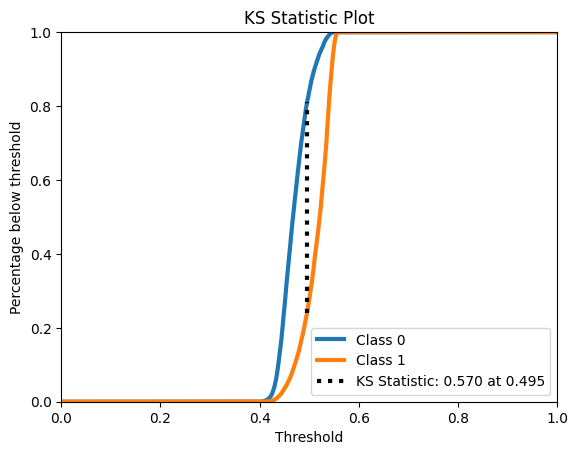

[I 2024-07-18 18:10:40,230] Trial 44 finished with values: [0.8519853982701144, 0.5699428235837858] and parameters: {'n_hidden_layers': 320, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 320
activation_function:sigmoid
optimizer:SGD
batch_size:96

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8520
AUPR:             0.8297
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.8877 - loss: 0.4262 - val_auc: 0.9274 - val_loss: 0.3670
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9261 - loss: 0.3462 - val_auc: 0.9278 - val_loss: 0.3475
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.9254 - loss: 0.3466 - val_auc: 0.9301 - val_loss: 0.3660
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9269 - loss: 0.3423 - val_auc: 0.9321 - val_loss: 0.3341
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9288 - loss: 0.3366 - val_auc: 0.9373 - val_loss: 0.3329
508/508 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step


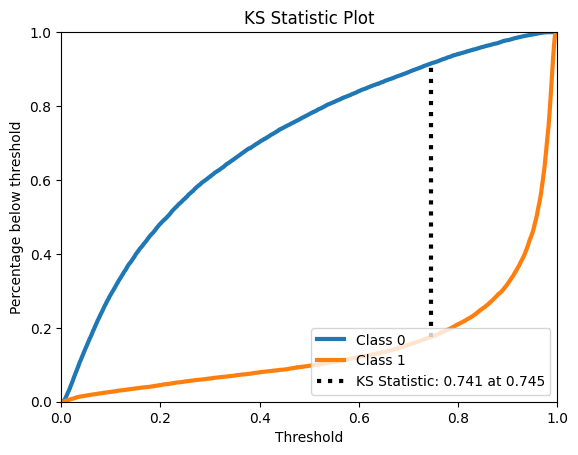

[I 2024-07-18 18:10:45,331] Trial 45 finished with values: [0.9274159842003246, 0.7406321893730408] and parameters: {'n_hidden_layers': 160, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 160
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9274
AUPR:             0.9318
Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5358 - loss: 0.7045 - val_auc: 0.8369 - val_loss: 0.6526
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.6472 - loss: 0.6610 - val_auc: 0.8642 - val_loss: 0.6197
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7260 - loss: 0.6286 - val_auc: 0.8727 - val_loss: 0.5912
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7706 - loss: 0.6018 - val_auc: 0.8772 - val_loss: 0.5639
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7981 - loss: 0.5786 - val_auc: 0.8803 - val_loss: 0.5406
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


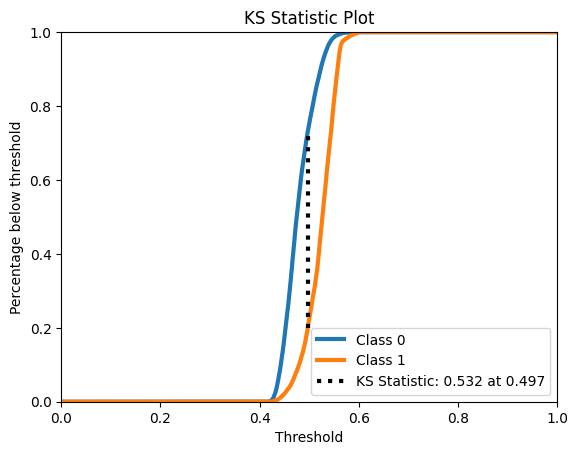

[I 2024-07-18 18:10:49,203] Trial 46 finished with values: [0.837507261862344, 0.5321433199797252] and parameters: {'n_hidden_layers': 320, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 128}. 




MLP
n_hidden_layers: 320
activation_function:sigmoid
optimizer:SGD
batch_size:128

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.8375
AUPR:             0.7921
Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7700 - loss: 0.5753 - val_auc: 0.9149 - val_loss: 0.3805
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9091 - loss: 0.3885 - val_auc: 0.9233 - val_loss: 0.3570
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9169 - loss: 0.3712 - val_auc: 0.9254 - val_loss: 0.3594
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9193 - loss: 0.3671 - val_auc: 0.9259 - val_loss: 0.3560
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9197 - loss: 0.3644 - val_auc: 0.9265 - val_loss: 0.3649
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


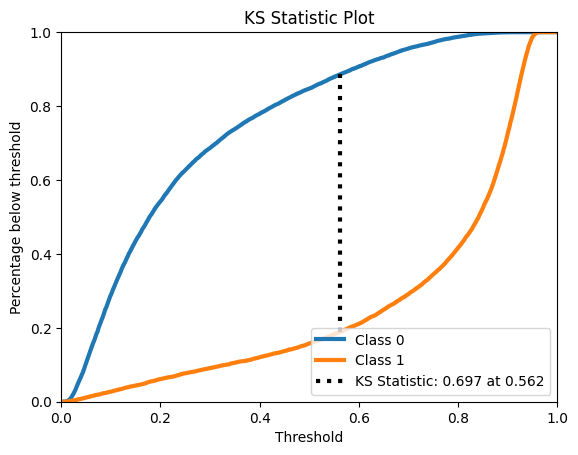

[I 2024-07-18 18:10:53,224] Trial 47 finished with values: [0.9151152300676, 0.6972708692479288] and parameters: {'n_hidden_layers': 410, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 410
activation_function:sigmoid
optimizer:rmsprop
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9151
AUPR:             0.9184
Epoch 1/100
7346/7346 ━━━━━━━━━━━━━━━━━━━━ 8s 983us/step - auc: 0.8872 - loss: 0.4174 - val_auc: 0.9629 - val_loss: 0.2533
Epoch 2/100
7346/7346 ━━━━━━━━━━━━━━━━━━━━ 7s 946us/step - auc: 0.9522 - loss: 0.2762 - val_auc: 0.9724 - val_loss: 0.2222
Epoch 3/100
7346/7346 ━━━━━━━━━━━━━━━━━━━━ 7s 928us/step - auc: 0.9596 - loss: 0.2552 - val_auc: 0.9783 - val_loss: 0.1962
Epoch 4/100
7346/7346 ━━━━━━━━━━━━━━━━━━━━ 7s 943us/step - auc: 0.9663 - loss: 0.2324 - val_auc: 0.9800 - val_loss: 0.1847
Epoch 5/100
7346/7346 ━━━━━━━━━━━━━━━━━━━━ 7s 958us/step - auc: 0.9698 - loss: 0.2203 - val_auc: 0.9824 - val_loss: 0.1764
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


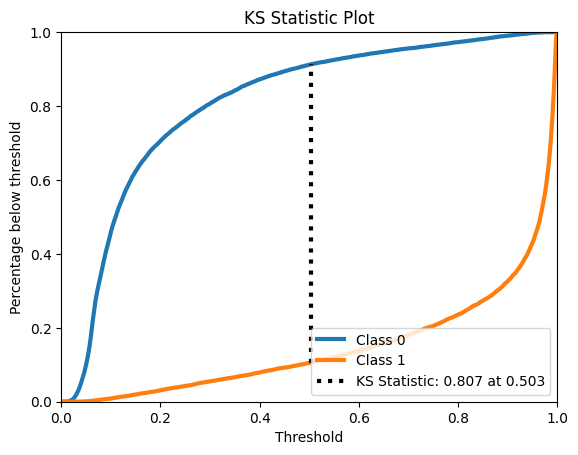

[I 2024-07-18 18:11:30,112] Trial 48 finished with values: [0.963771887880308, 0.8074760348071568] and parameters: {'n_hidden_layers': 10, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 10
activation_function:relu
optimizer:adam
batch_size:32

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9638
AUPR:             0.9609
Epoch 1/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.8919 - loss: 0.4169 - val_auc: 0.9489 - val_loss: 0.2933
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9515 - loss: 0.2793 - val_auc: 0.9704 - val_loss: 0.2258
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9695 - loss: 0.2259 - val_auc: 0.9766 - val_loss: 0.1989
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9763 - loss: 0.1995 - val_auc: 0.9791 - val_loss: 0.1940
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.9789 - loss: 0.1876 - val_auc: 0.9827 - val_loss: 0.1677
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step


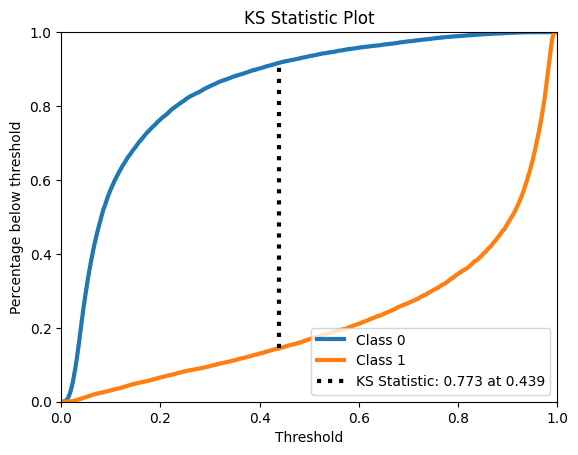

[I 2024-07-18 18:11:35,133] Trial 49 finished with values: [0.9490203704124692, 0.7725561687123604] and parameters: {'n_hidden_layers': 120, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 120
activation_function:relu
optimizer:rmsprop
batch_size:160

Accuracy:         0.9507
Recall:           0.9380
Precision:        0.9481
F1:               0.9430
AUROC:            0.9490
AUPR:             0.9488


In [84]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=50)

#### Salvando os resultados no csv e visualizando os resultados

In [85]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "../results/optuna_results_mlp.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [86]:
df_existing

,number,values_0,values_1,params_activation_function,params_batch_size,params_n_hidden_layers,params_optimizer,user_attrs_accuracy,user_attrs_activation_function,user_attrs_auroc,user_attrs_batch_size,user_attrs_f1,user_attrs_ks_statistic,user_attrs_max_distance_at,user_attrs_n_hidden_layers,user_attrs_optimizer,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
10,10,0.431994,0.045550,softmax,64,220,SGD,0.950724,softmax,0.431994,64,0.948055,0.045550,0.500170,220,SGD,0.948055,0.937974,0
3,3,0.463689,0.050850,softmax,64,280,SGD,0.950724,softmax,0.463689,64,0.948055,0.050850,0.499692,280,SGD,0.948055,0.937974,0
37,37,0.675989,0.266699,softmax,64,180,SGD,0.950724,softmax,0.675989,64,0.948055,0.266699,0.500848,180,SGD,0.948055,0.937974,0
39,39,0.820313,0.506949,softmax,64,40,SGD,0.950724,softmax,0.820313,64,0.948055,0.506949,0.505659,40,SGD,0.948055,0.937974,0
46,46,0.837507,0.532143,sigmoid,128,320,SGD,0.950724,sigmoid,0.837507,128,0.948055,0.532143,0.496873,320,SGD,0.948055,0.937974,0
44,44,0.851985,0.569943,sigmoid,96,320,SGD,0.950724,sigmoid,0.851985,96,0.948055,0.569943,0.495476,320,SGD,0.948055,0.937974,0
28,28,0.864162,0.576904,tanh,64,310,SGD,0.950724,tanh,0.864162,64,0.948055,0.576904,0.481713,310,SGD,0.948055,0.937974,0
34,34,0.864373,0.574719,tanh,160,500,SGD,0.950724,tanh,0.864373,160,0.948055,0.574719,0.596859,500,SGD,0.948055,0.937974,0
23,23,0.866019,0.571772,tanh,32,330,SGD,0.950724,tanh,0.866019,32,0.948055,0.571772,0.495064,330,SGD,0.948055,0.937974,0
26,26,0.868019,0.583002,tanh,96,460,SGD,0.950724,tanh,0.868019,96,0.948055,0.583002,0.598386,460,SGD,0.948055,0.937974,0


In [87]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9507237449953804
  Precision: 0.9480547395572114
  Recall:    0.9379740554334728
  F1 Score:  0.9480547395572114
  auroc:  0.9906909750735002
  ks_statistic:  0.8998487536082326
  max_distance_at:  0.48135828971862793
  Parameters: 
    n_hidden_layers:  60
    activation_function: relu
    optimizer:        rmsprop
    batch_size:       64

-- Overall Results (Ordered by auroc) --
    number  values_0  values_1 params_activation_function  params_batch_size  \
10      10  0.431994  0.045550                    softmax                 64   
3        3  0.463689  0.050850                    softmax                 64   
37      37  0.675989  0.266699                    softmax                 64   
39      39  0.820313  0.506949                    softmax                 64   
46      46  0.837507  0.532143                    sigmoid                128   
44      44  0.851985  0.569943                    sigmoid                 96   
28      28  0.864162  